In [2]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule, UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [ ]:
from qiskit import Aer, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map

IBMQ.save_account('')
provider = IBMQ.get_provider(hub='ibm-q-research-2')
provider.backends()


# NaH

In [15]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Na", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [16]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -158.80188 Exact Energy: -158.80193
Interatomic Distance: 0.7 VQE Result: -159.52647 Exact Energy: -159.52649
Interatomic Distance: 0.9 VQE Result: -159.92208 Exact Energy: -159.92214
Interatomic Distance: 1.1 VQE Result: -160.15695 Exact Energy: -160.15700
Interatomic Distance: 1.3 VQE Result: -160.27199 Exact Energy: -160.27202
Interatomic Distance: 1.5 VQE Result: -160.31891 Exact Energy: -160.31895
Interatomic Distance: 1.7 VQE Result: -160.32735 Exact Energy: -160.32742
Interatomic Distance: 1.9 VQE Result: -160.31391 Exact Energy: -160.31400
Interatomic Distance: 2.1 VQE Result: -160.28893 Exact Energy: -160.28899
Interatomic Distance: 2.3 VQE Result: -160.25904 Exact Energy: -160.25917
Interatomic Distance: 2.5 VQE Result: -160.22872 Exact Energy: -160.22897
Interatomic Distance: 2.7 VQE Result: -160.20011 Exact Energy: -160.20114
Interatomic Distance: 2.9 VQE Result: -160.17628 Exact Energy: -160.17725
Interatomic Distance: 3.1 VQE Result: 

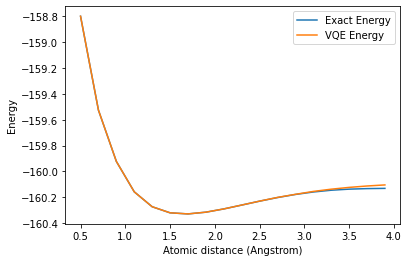

In [13]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Energia esperada : -160.315703 hartree
### Distanscia esperada : 1.8874


In [17]:
qubit_op.num_qubits

8

In [18]:
var_form.num_qubits

8

# BeH2

In [ ]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Be", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]],
            ["H", [-dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

## H2

In [3]:
def get_qubit_op2(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])
                              # remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    #print(second_q_ops)
    # Get Hamiltonian
    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [4]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = Aer.get_backend("statevector_simulator")
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 2.70996 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.15748 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.

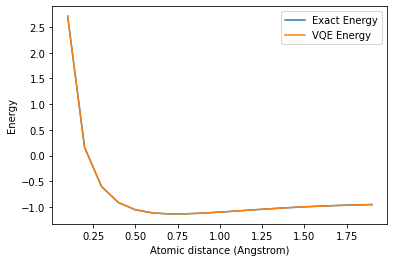

In [5]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [26]:
var_form.num_qubits

2

In [27]:
qubit_op.num_qubits

2

#### Simulador lagos

In [27]:
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=100)
#
#Get noise model
backend_device = provider.get_backend('ibm_lagos')
print("Running on: ", backend_device)
sim_device = AerSimulator.from_backend(backend_device)

coupling_map = sim_device.configuration().coupling_map
qi = QuantumInstance(sim_device,
                    coupling_map=coupling_map,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Running on:  ibm_lagos
Interatomic Distance: 0.1 VQE Result: 2.78832 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.21043 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.51200 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.88489 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -0.98622 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.07058 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.09907 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.10996 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.09448 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.06902 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.03856 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.04979 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.01126 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01386 Exact Energy: -1.01547
I

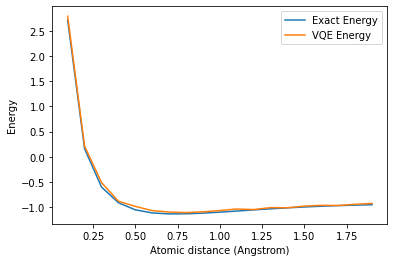

In [28]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Computador quantico real

In [19]:
backend_device = provider.get_backend('ibm_lagos')
print("Running on: ", backend_device)
sim_device = AerSimulator.from_backend(backend_device)

Running on:  ibm_lagos


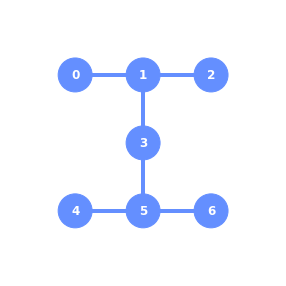

In [21]:
plot_gate_map(backend_device)

In [26]:
properties = backend_device.properties()

properties.to_dict()

{'backend_name': 'ibm_lagos',
 'backend_version': '1.2.1',
 'last_update_date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
 'qubits': [[{'date': datetime.datetime(2023, 1, 14, 14, 50, 24, tzinfo=tzlocal()),
    'name': 'T1',
    'unit': 'us',
    'value': 130.98083750865038},
   {'date': datetime.datetime(2023, 1, 14, 5, 49, 10, tzinfo=tzlocal()),
    'name': 'T2',
    'unit': 'us',
    'value': 44.223363675526144},
   {'date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
    'name': 'frequency',
    'unit': 'GHz',
    'value': 5.235357861207796},
   {'date': datetime.datetime(2023, 1, 14, 15, 40, 43, tzinfo=tzlocal()),
    'name': 'anharmonicity',
    'unit': 'GHz',
    'value': -0.33986713855915607},
   {'date': datetime.datetime(2023, 1, 14, 5, 44, 19, tzinfo=tzlocal()),
    'name': 'readout_error',
    'unit': '',
    'value': 0.011700000000000044},
   {'date': datetime.datetime(2023, 1, 14, 5, 44, 19, tzinfo=tzlocal()),
    'name': 'prob_meas0_p

In [ ]:
distances = np.arange(0.1, 2, 0.1)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=100)


coupling_map = backend_device.configuration().coupling_map
qi = QuantumInstance(backend_device,
                    measurement_error_mitigation_cls=CompleteMeasFitter)
# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op2(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    optimizer = SPSA(maxiter=100)
    var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
    vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
    vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result[0]:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")